Métodos de la clase gymnasium:

reset(self) : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.

step(self, action) : "Avanza" un timestep. Devuelve: observation, reward, done, info.

render(self) : Muestra en pantalla el entorno.

close(self) : Finaliza con la instancia del agente.

seed(self) : Establece la semilla aleatoria del generador de números aleatorios del presente entorno.

Atributos de la clase gymnasium:

action_space : El objeto de tipo Space correspondiente al espacio de acciones válidas.

observation_space : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

reward_range : Tupla que contiene los valores mínimo y máximo de recompensa posible.

In [1]:
import gymnasium as gym
import numpy as npy
import random as rng
import matplotlib.pyplot as plot

Para calcular la posición en la matriz he empleado la siguiente fórmula:

20 * (A - minSuma) + (B - 1) + 10 * C

Siendo A la suma acumulada del jugador, B la carta que muestra el dealer y C es 1 o 0 en función de si el as se usa como 11 o como 1 respectivamente

minSuma es la suma mínima que puede acumular el jugador, es decir, 4

La matriz tiene 360 posiciones puesto que max(A) = 21, max(B) = 10 y max(C) = 1 que al sustituirlo en la fórmula da 359 (cuando la suma del jugador supere 21 se devolverá un valor negativo para indicar que es una acción penalizada)

In [66]:
env = gym.make('Blackjack-v1', natural=True, sab=False)
#env = gym.make('Blackjack-v1', natural=False, sab=False, render_mode = "human")

maxValor = 360
#Inicializo toda la Matriz Q-Learning a 0 (Dimensiones de 360x2)
matrizQ = npy.zeros([maxValor, env.action_space.n])

Celda de parámetros

In [ ]:
reiniciado = npy.all(matrizQ == 0) #Miro si la matriz Q ha sido reiniciada o no
premios = [] #Lista que almacena la cantidad de premios que ha habido en cada simulacion
castigos = [] #Lista que almacena la cantidad de castigos que ha habido en cada simulacion
a = 0.75 #Valor de alpha (α) 
y = 0.75 #Valor de gamma (γ)
e = 0.1 #Valor de epsilon (ε)
episodios = 1000 #Numero de episodios que se van a ejecutar por simulacion
ourMod = 1 #Modificador auxiliar por si queremos aumentar o disminuir la recompensa predeterminada
#castigos = 0 #Numero de penalizaciones que se han recibido
minSuma = 4 #Valor necesario para calcular las posiciones en la matriz
dinamico = True

Celda de simulación

In [ ]:
contCastigos = 0
contPremios = 0
for i in range(episodios):

    if dinamico:
        #a = 1 - (i/(episodios+1))
        #y = i/(episodios+1)
        e = 1 - (i/(episodios + 1))

    estado = env.reset()
    A, B, C = estado[0]
    pos =  20 * (A - minSuma) + (B - 1) + 10 * C
    done = False

    while not done:
        #env.render()
        if(rng.uniform(0, 1) < e): #Exploracion
            accion = env.action_space.sample()
        else: #Explotacion
            accion = npy.argmax(matrizQ[pos]) 

        estadoNext, recompensa, done, info, info2 = env.step(accion)

        recompensa *= ourMod
        nextA, nextB, nextC = estadoNext
        posNext = 20 * (nextA - minSuma) +  (nextB - 1) + 10 * nextC
        #Si posNext >= maxValor significa que tengo una suma superior a 21
        siguienteMax = npy.max(matrizQ[posNext]) if posNext < maxValor else -ourMod

        valorAntiguo = matrizQ[pos, accion]
        valorNuevo = (1 - a) * valorAntiguo + a * (recompensa + y * siguienteMax)
        matrizQ[pos, accion] = valorNuevo
        
        if recompensa < 0: contCastigos += 1
        elif recompensa > 0: contPremios += 1
        
        estado = estadoNext
        pos = posNext

#env.close()
premios.append(contPremios)
castigos.append(contCastigos)


Episodio Nº0

Estado inicial: (20, 7, 0)
Posicion en la matriz: 326
··························
Pide
Estado siguiente: (21, 7, 0)
Posicion en la matriz: 346
Recompensa: 0.0
Valor previo a la accion: -1.7499997876586093
Valor posterior a la accion: 1.469725860733831
··························
Se planta
Estado siguiente: (21, 7, 0)
Posicion en la matriz: 346
Recompensa: 1.0
Valor previo a la accion: 3.390623658041748
Valor posterior a la accion: 3.5048817221589204


Episodio Nº1

Estado inicial: (14, 10, 0)
Posicion en la matriz: 209
··························
Pide
Estado siguiente: (24, 10, 0)
Posicion en la matriz: 409
Recompensa: -1.0
Valor previo a la accion: -0.8801420184533854
Valor posterior a la accion: -1.5325355046133464


Episodio Nº2

Estado inicial: (19, 10, 0)
Posicion en la matriz: 309
··························
Se planta
Estado siguiente: (19, 10, 0)
Posicion en la matriz: 309
Recompensa: -1.0
Valor previo a la accion: -1.5971731217308767
Valor posterior a la accion: -2.04

Celdas de gráfico

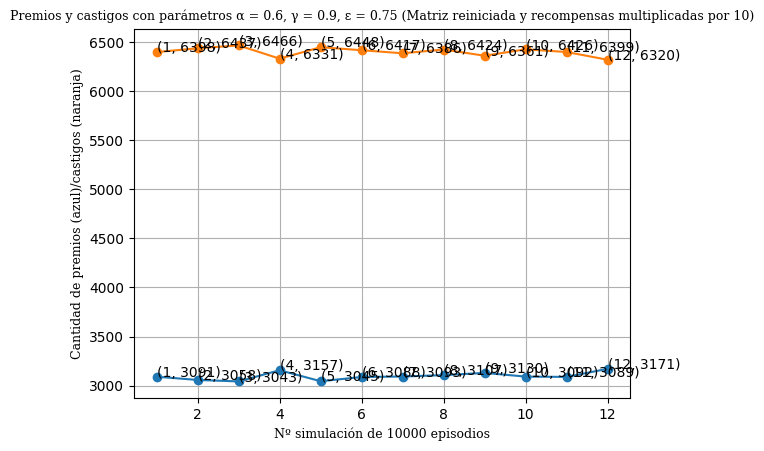

In [19]:
x = [i for i in range(1, len(premios) + 1)]
plot.plot(x, premios, marker = 'o')
plot.plot(x, castigos, marker = 'o')

for ab in zip(x, premios):
    plot.annotate('(%d, %d)' % ab, xy = ab)

for ab in zip(x, castigos):
    plot.annotate('(%d, %d)' % ab, xy = ab)

font = {'family':'serif', 'color':'black', 'size': 9}
plot.ylabel("Cantidad de premios (azul)/castigos (naranja)", fontdict = font)
plot.xlabel("Nº simulación de {} episodios".format(episodios), fontdict = font)
plot.title("Premios y castigos con parámetros α = {}, γ = {}, ε = {} (Matriz {} y recompensas multiplicadas por {})".format(a, y, e
            ,"reiniciada" if reiniciado else "sin reiniciar", ourMod), fontdict = font)
plot.grid()
plot.show()

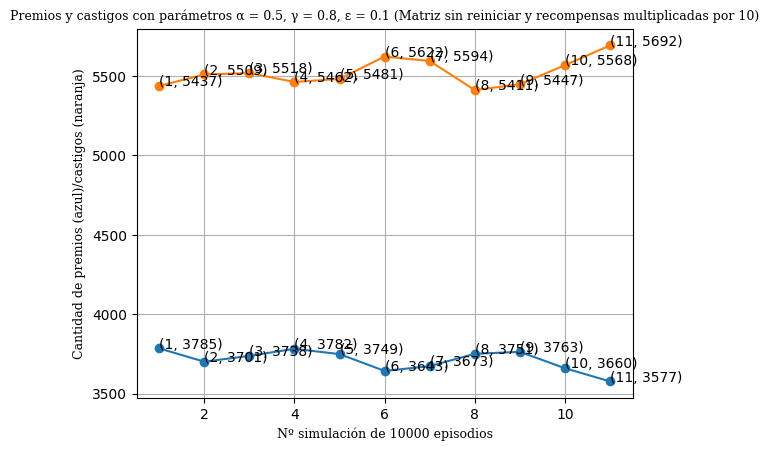

In [32]:
x = [i for i in range(1, len(premios) + 1)]
plot.plot(x, premios, marker = 'o')
plot.plot(x, castigos, marker = 'o')

for ab in zip(x, premios):
    plot.annotate('(%d, %d)' % ab, xy = ab)

for ab in zip(x, castigos):
    plot.annotate('(%d, %d)' % ab, xy = ab)

font = {'family':'serif', 'color':'black', 'size': 9}
plot.ylabel("Cantidad de premios (azul)/castigos (naranja)", fontdict = font)
plot.xlabel("Nº simulación de {} episodios".format(episodios), fontdict = font)
plot.title("Premios y castigos con parámetros α = {}, γ = {}, ε = {} (Matriz {} y recompensas multiplicadas por {})".format(a, y, e
            ,"reiniciada" if reiniciado else "sin reiniciar", ourMod), fontdict = font)
plot.grid()
plot.show()

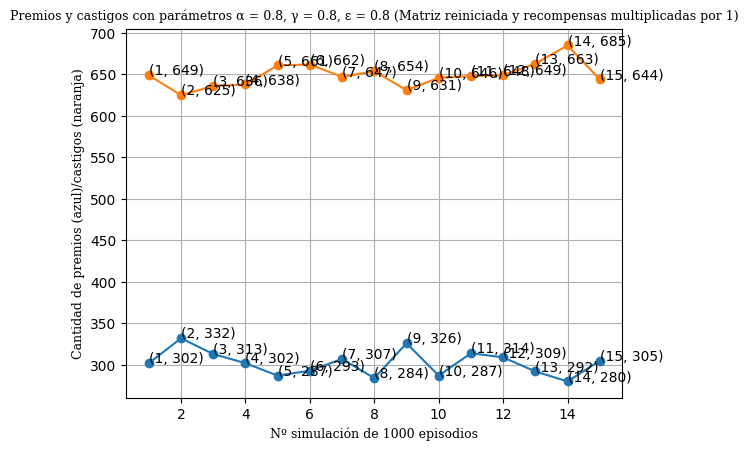

In [50]:
x = [i for i in range(1, len(premios) + 1)]
plot.plot(x, premios, marker = 'o')
plot.plot(x, castigos, marker = 'o')

for ab in zip(x, premios):
    plot.annotate('(%d, %d)' % ab, xy = ab)

for ab in zip(x, castigos):
    plot.annotate('(%d, %d)' % ab, xy = ab)

font = {'family':'serif', 'color':'black', 'size': 9}
plot.ylabel("Cantidad de premios (azul)/castigos (naranja)", fontdict = font)
plot.xlabel("Nº simulación de {} episodios".format(episodios), fontdict = font)
plot.title("Premios y castigos con parámetros α = {}, γ = {}, ε = {} (Matriz {} y recompensas multiplicadas por {})".format(a, y, e
            ,"reiniciada" if reiniciado else "sin reiniciar", ourMod), fontdict = font)
plot.grid()
plot.show()

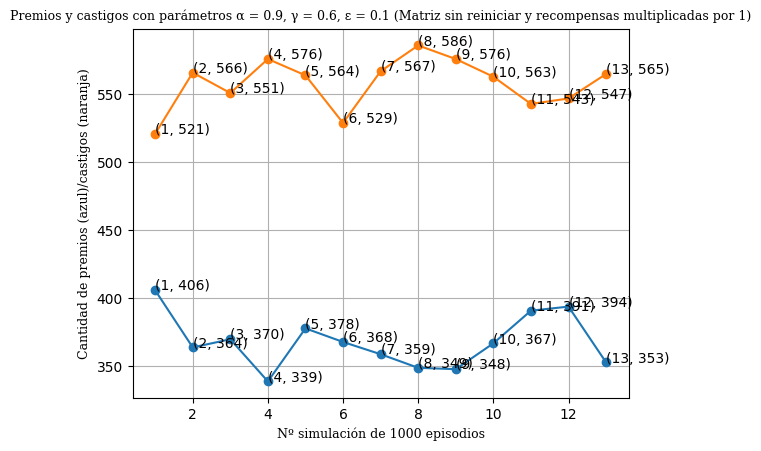

In [65]:
x = [i for i in range(1, len(premios) + 1)]
plot.plot(x, premios, marker = 'o')
plot.plot(x, castigos, marker = 'o')

for ab in zip(x, premios):
    plot.annotate('(%d, %d)' % ab, xy = ab)

for ab in zip(x, castigos):
    plot.annotate('(%d, %d)' % ab, xy = ab)

font = {'family':'serif', 'color':'black', 'size': 9}
plot.ylabel("Cantidad de premios (azul)/castigos (naranja)", fontdict = font)
plot.xlabel("Nº simulación de {} episodios".format(episodios), fontdict = font)
plot.title("Premios y castigos con parámetros α = {}, γ = {}, ε = {} (Matriz {} y recompensas multiplicadas por {})".format(a, y, e
            ,"reiniciada" if reiniciado else "sin reiniciar", ourMod), fontdict = font)
plot.grid()
plot.show()

Pruebas hechas con un ε dinámico

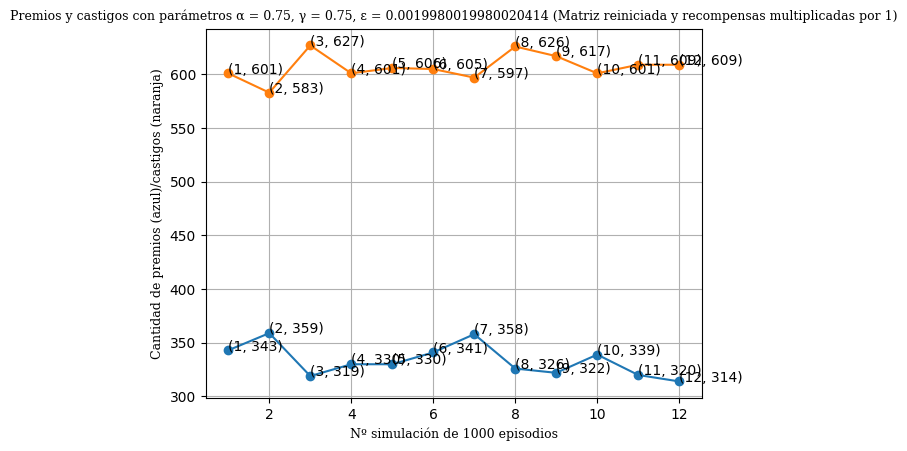

In [80]:
x = [i for i in range(1, len(premios) + 1)]
plot.plot(x, premios, marker = 'o')
plot.plot(x, castigos, marker = 'o')

for ab in zip(x, premios):
    plot.annotate('(%d, %d)' % ab, xy = ab)

for ab in zip(x, castigos):
    plot.annotate('(%d, %d)' % ab, xy = ab)

font = {'family':'serif', 'color':'black', 'size': 9}
plot.ylabel("Cantidad de premios (azul)/castigos (naranja)", fontdict = font)
plot.xlabel("Nº simulación de {} episodios".format(episodios), fontdict = font)
plot.title("Premios y castigos con parámetros α = {}, γ = {}, ε = {} (Matriz {} y recompensas multiplicadas por {})".format(a, y, e
            ,"reiniciada" if reiniciado else "sin reiniciar", ourMod), fontdict = font)
plot.grid()
plot.show()

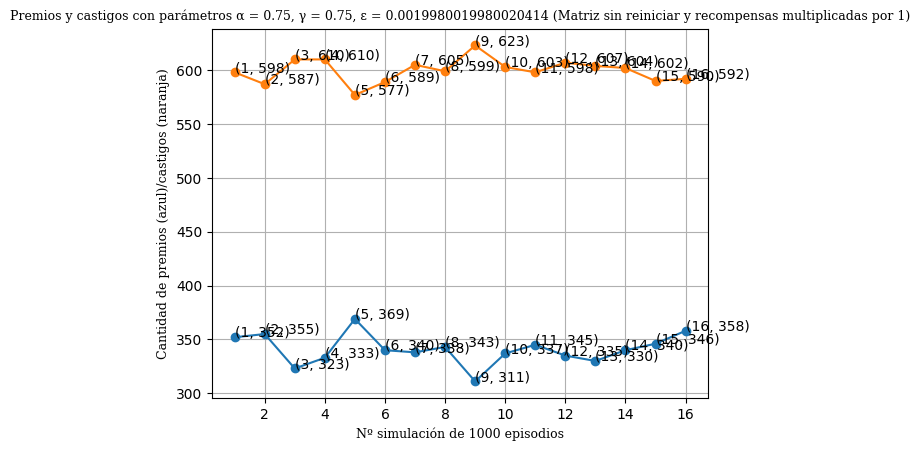

In [98]:
x = [i for i in range(1, len(premios) + 1)]
plot.plot(x, premios, marker = 'o')
plot.plot(x, castigos, marker = 'o')

for ab in zip(x, premios):
    plot.annotate('(%d, %d)' % ab, xy = ab)

for ab in zip(x, castigos):
    plot.annotate('(%d, %d)' % ab, xy = ab)

font = {'family':'serif', 'color':'black', 'size': 9}
plot.ylabel("Cantidad de premios (azul)/castigos (naranja)", fontdict = font)
plot.xlabel("Nº simulación de {} episodios".format(episodios), fontdict = font)
plot.title("Premios y castigos con parámetros α = {}, γ = {}, ε = {} (Matriz {} y recompensas multiplicadas por {})".format(a, y, e
            ,"reiniciada" if reiniciado else "sin reiniciar", ourMod), fontdict = font)
plot.grid()
plot.show()

In [ ]:
x = [i for i in range(1, len(premios) + 1)]
plot.plot(x, premios, marker = 'o')
plot.plot(x, castigos, marker = 'o')

for ab in zip(x, premios):
    plot.annotate('(%d, %d)' % ab, xy = ab)

for ab in zip(x, castigos):
    plot.annotate('(%d, %d)' % ab, xy = ab)

font = {'family':'serif', 'color':'black', 'size': 9}
plot.ylabel("Cantidad de premios (azul)/castigos (naranja)", fontdict = font)
plot.xlabel("Nº simulación de {} episodios".format(episodios), fontdict = font)
plot.title("Premios y castigos con parámetros α = {}, γ = {}, ε = {} (Matriz {} y recompensas multiplicadas por {})".format(a, y, e
            ,"reiniciada" if reiniciado else "sin reiniciar", ourMod), fontdict = font)
plot.grid()
plot.show()

In [ ]:
x = [i for i in range(1, len(premios) + 1)]
plot.plot(x, premios, marker = 'o')
plot.plot(x, castigos, marker = 'o')

for ab in zip(x, premios):
    plot.annotate('(%d, %d)' % ab, xy = ab)

for ab in zip(x, castigos):
    plot.annotate('(%d, %d)' % ab, xy = ab)

font = {'family':'serif', 'color':'black', 'size': 9}
plot.ylabel("Cantidad de premios (azul)/castigos (naranja)", fontdict = font)
plot.xlabel("Nº simulación de {} episodios".format(episodios), fontdict = font)
plot.title("Premios y castigos con parámetros α = {}, γ = {}, ε = {} (Matriz {} y recompensas multiplicadas por {})".format(a, y, e
            ,"reiniciada" if reiniciado else "sin reiniciar", ourMod), fontdict = font)
plot.grid()
plot.show()

In [ ]:
x = [i for i in range(1, len(premios) + 1)]
plot.plot(x, premios, marker = 'o')
plot.plot(x, castigos, marker = 'o')

for ab in zip(x, premios):
    plot.annotate('(%d, %d)' % ab, xy = ab)

for ab in zip(x, castigos):
    plot.annotate('(%d, %d)' % ab, xy = ab)

font = {'family':'serif', 'color':'black', 'size': 9}
plot.ylabel("Cantidad de premios (azul)/castigos (naranja)", fontdict = font)
plot.xlabel("Nº simulación de {} episodios".format(episodios), fontdict = font)
plot.title("Premios y castigos con parámetros α = {}, γ = {}, ε = {} (Matriz {} y recompensas multiplicadas por {})".format(a, y, e
            ,"reiniciada" if reiniciado else "sin reiniciar", ourMod), fontdict = font)
plot.grid()
plot.show()